In [67]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, TimestampType

#Branch Schema
branch_schema = StructType([
    StructField("BRANCH_CODE", IntegerType(), True),
    StructField("BRANCH_NAME", StringType(), True),
    StructField("BRANCH_STREET", StringType(), True),
    StructField("BRANCH_CITY", StringType(), True),
    StructField("BRANCH_STATE", StringType(), True),
    StructField("BRANCH_ZIP", IntegerType(), True),
    StructField("BRANCH_PHONE", StringType(), True),
    StructField("LAST_UPDATED", TimestampType(), True)
])

spark = SparkSession.builder.appName("JsonExtraction").getOrCreate()

branch_data = spark.read.json("cdw_sapp_branch.json")





In [68]:
branch_data.createOrReplaceTempView("branch_data")

In [69]:
#Extracting the transformed Branch Data
transformed_branch_data = spark.sql("""
    SELECT
        CAST(BRANCH_CODE AS INT) AS BRANCH_CODE,
        BRANCH_NAME AS BRANCH_NAME,
        BRANCH_STREET AS BRANCH_STREET,
        BRANCH_CITY AS BRANCH_CITY,
        BRANCH_STATE AS BRANCH_STATE,
        CASE
            WHEN BRANCH_ZIP IS NULL THEN 99999
            ELSE CAST(BRANCH_ZIP AS INT)
        END AS BRANCH_ZIP,
        CASE
            WHEN BRANCH_PHONE RLIKE '\\d{10}'
            THEN CONCAT('(', SUBSTR(BRANCH_PHONE, 1, 3), ')', SUBSTR(BRANCH_PHONE, 4, 3), '-', SUBSTR(BRANCH_PHONE, 7, 4))
            ELSE BRANCH_PHONE
        END AS BRANCH_PHONE,
        LAST_UPDATED AS LAST_UPDATED
    FROM branch_data
""")

transformed_branch_data.show()

+-----------+------------+-------------------+-----------------+------------+----------+------------+--------------------+
|BRANCH_CODE| BRANCH_NAME|      BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP|BRANCH_PHONE|        LAST_UPDATED|
+-----------+------------+-------------------+-----------------+------------+----------+------------+--------------------+
|          1|Example Bank|       Bridle Court|        Lakeville|          MN|     55044|  1234565276|2018-04-18T16:51:...|
|          2|Example Bank|  Washington Street|          Huntley|          IL|     60142|  1234618993|2018-04-18T16:51:...|
|          3|Example Bank|      Warren Street|SouthRichmondHill|          NY|     11419|  1234985926|2018-04-18T16:51:...|
|          4|Example Bank|   Cleveland Street|       Middleburg|          FL|     32068|  1234663064|2018-04-18T16:51:...|
|          5|Example Bank|        14th Street|    KingOfPrussia|          PA|     19406|  1234849701|2018-04-18T16:51:...|
|          7|Exa

In [70]:
#Customer Schema

schema_customer = StructType([
    StructField("SSN", IntegerType(), True),
    StructField("FIRST_NAME", StringType(), True),
    StructField("MIDDLE_NAME", StringType(), True),
    StructField("LAST_NAME", StringType(), True),
    StructField("CREDIT_CARD_NO", StringType(), True),
    StructField("STREET_NAME", StringType(), True),
    StructField("APT_NO", StringType(), True),
    StructField("CUST_CITY", StringType(), True),
    StructField("CUST_STATE", StringType(), True),
    StructField("CUST_COUNTRY", StringType(), True),
    StructField("CUST_ZIP", IntegerType(), True),
    StructField("CUST_PHONE", StringType(), True),
    StructField("CUST_EMAIL", StringType(), True),
    StructField("LAST_UPDATED", TimestampType(), True)
])


In [71]:
#Reading json file with schema
customer_data = spark.read.schema(schema_customer).json("cdw_sapp_custmer.json") 

In [72]:
#Temp view for customer data
customer_data.createOrReplaceTempView("customer_data")

In [73]:
# Write SQL queries based on the qualified column names
transformed_customer_data = spark.sql("""
    SELECT
        CAST(customer_data.SSN AS INT) AS SSN,
        INITCAP(customer_data.FIRST_NAME) AS FIRST_NAME,
        LOWER(customer_data.MIDDLE_NAME) AS MIDDLE_NAME,
        INITCAP(customer_data.LAST_NAME) AS LAST_NAME,
        customer_data.CREDIT_CARD_NO AS Credit_card_no,
        CONCAT_WS(', ', customer_data.APT_NO, customer_data.STREET_NAME) AS FULL_STREET_ADDRESS,
        customer_data.CUST_CITY AS CUST_CITY,
        customer_data.CUST_STATE AS CUST_STATE,
        customer_data.CUST_COUNTRY AS CUST_COUNTRY,
        CAST(COALESCE(customer_data.CUST_ZIP, 99999) AS INT) AS CUST_ZIP,
        CASE
            WHEN customer_data.CUST_PHONE RLIKE '\\d{10}'
            THEN CONCAT('(', SUBSTR(customer_data.CUST_PHONE, 1, 3), ')', SUBSTR(customer_data.CUST_PHONE, 4, 3), '-', SUBSTR(customer_data.CUST_PHONE, 7, 4))
            ELSE customer_data.CUST_PHONE
        END AS CUST_PHONE,
        customer_data.CUST_EMAIL AS CUST_EMAIL,
        customer_data.LAST_UPDATED AS LAST_UPDATED
    FROM customer_data
""")


transformed_customer_data.show()

+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+----------+--------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|CUST_PHONE|          CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+----------+--------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|656, Main Street ...|     Natchez|        MS|United States|   99999|   1237818| AHooper@example.com|2018-04-21 09:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  829, Redwood Drive|Wethersfield|        CT|United States|   99999|   1238933| EHolman@example.com|2018-04-21 09:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|683, 12th Street ...|     Hun

In [74]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, col
import secret

# Initialize a Spark session
spark = SparkSession.builder.appName("CreditCardDataLoader").getOrCreate()
# Define the input file path and read the JSON data
input_file = "C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/cdw_sapp_credit.json"
df = spark.read.json(input_file)
# Convert DAY, MONTH, YEAR to TIMEID (YYYYMMDD)
df = df.withColumn("TIMEID", concat(df["YEAR"], lit("-"), df["MONTH"], lit("-"), df["DAY"]))
# Rename columns and select required columns
df = df.select(
    col("CREDIT_CARD_NO").alias("CUST_CC_NO"),
    "TIMEID",
    "CUST_SSN",
    "BRANCH_CODE",
    "TRANSACTION_TYPE",
    "TRANSACTION_VALUE",
    "TRANSACTION_ID"
)
# Database connection details
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "password": secret.mysql_password,
    "database": "creditcard_capstone"
}
# Write the DataFrame to the MySQL database
df.write.format("jdbc").options(
    url="jdbc:mysql://{0}/{1}".format(db_config["host"], db_config["database"]),
    driver="com.mysql.cj.jdbc.Driver",
    dbtable="CDW_SAPP_CREDIT_CARD",
    user=db_config["user"],
    password=db_config["password"]
).mode("overwrite").save()
# Close the Spark session
spark.stop()

In [75]:
import mysql.connector
import secret


spark = SparkSession.builder.appName("CreditCardSystemLoader").getOrCreate()

# Load the transformed data into DataFrames (replace with your DataFrames)
branch_data = transformed_branch_data
customer_data = transformed_customer_data


db = mysql.connector.connect(
    host = "localhost",
    user = secret.mysql_username,
    passwd = secret.mysql_password,
    database = "creditcard_capstone" #Database in mysql

)


# Write DataFrames to MySQL tables using the existing MySQL connection
branch_data.write \
    .format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "CDW_SAPP_BRANCH") \
    .option("mode", "overwrite") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("user", secret.mysql_username) \
    .option("password", secret.mysql_password) \
    .save()
customer_data.write \
    .format("jdbc") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "CDW_SAPP_CUSTOMER") \
    .option("mode", "overwrite") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("user", secret.mysql_username) \
    .option("password", secret.mysql_password) \
    .save()
# Stop the Spark session
spark.stop()
# Close the MySQL connection
db.close()

AnalysisException: Table or view 'CDW_SAPP_BRANCH' already exists. SaveMode: ErrorIfExists.

In [76]:
#Req 2.1
import mysql.connector as mysql
import secret
def establish_db_connection():
    # Define your database connection details and connect
    db = mysql.connect(
        host="localhost",
        user=secret.mysql_username,
        passwd=secret.mysql_password,
        database="creditcard_capstone"  # Database in MySQL
    )
    return db, db.cursor()
def check_customer_details(cursor, customer_id):
    # SQL query to retrieve customer details
    query = "SELECT * FROM CDW_SAPP_CUSTOMER WHERE SSN = %s"
    cursor.execute(query, (customer_id,))
    customer_details = cursor.fetchone()
    if customer_details:
        print("Customer Details:")
        print("SSN:", customer_details[0])
        print("First Name:", customer_details[1])
        print("Last Name:", customer_details[2])
        # Display other customer details
    else:
        print("Customer not found.")
def modify_customer_details(cursor, customer_id, new_email):
    # SQL query to update customer email
    query = "UPDATE CDW_SAPP_CUSTOMER SET CUST_EMAIL = %s WHERE SSN = %s"
    cursor.execute(query, (new_email, customer_id))
    cursor.db.commit()
    print("Customer email updated successfully.")
def generate_monthly_bill(cursor, credit_card_number, month, year):
    # SQL query to retrieve monthly bill details
    query = """
    SELECT * FROM CDW_SAPP_CREDIT_CARD
    WHERE YEAR(TIMEID) = %s AND MONTH(TIMEID) = %s AND CUST_CC_NO = %s
    ORDER BY TIMEID DESC;
    """
    cursor.execute(query, (year, month, credit_card_number))
    monthly_bill = cursor.fetchall()
    if monthly_bill:
        print("Monthly Bill for Credit Card Number:", credit_card_number)
        for transaction in monthly_bill:
            print(transaction)
    else:
        print("No transactions found for the specified month and year.")
def display_transactions_between_dates(cursor, customer_id, start_date, end_date):
    # SQL query to retrieve transactions between two dates
    query = """
    SELECT * FROM CDW_SAPP_CREDIT_CARD
    WHERE TIMEID BETWEEN %s AND %s AND CUST_CC_NO = %s
    ORDER BY TIMEID DESC;
    """
    cursor.execute(query, (start_date, end_date, customer_id))
    transactions = cursor.fetchall()
    if transactions:
        print("Transactions between", start_date, "and", end_date)
        for transaction in transactions:
            print(transaction)
    else:
        print("No transactions found between the specified dates.")
def main():
    db, cursor = establish_db_connection()
    while True:
        print("Customer Details Module:")
        print("1. Check Customer Details")
        print("2. Modify Customer Email")
        print("3. Generate Monthly Bill")
        print("4. Display Customer Transactions Between Two Dates")
        print("5. Quit")
        choice = input("Enter your choice: ")
        if choice == "1":
            customer_id = input("Enter Customer SSN: ")
            check_customer_details(cursor, customer_id)
        elif choice == "2":
            customer_id = input("Enter Customer SSN: ")
            new_email = input("Enter New Email: ")
            modify_customer_details(cursor, customer_id, new_email)
        elif choice == "3":
            credit_card_number = input("Enter Credit Card Number: ")
            month = input("Enter Month (numeric): ")
            year = input("Enter Year (YYYY): ")
            generate_monthly_bill(cursor, credit_card_number, month, year)
        elif choice == "4":
            customer_id = input("Enter Customer SSN: ")
            start_date = input("Enter Start Date (YYYYMMDD): ")
            end_date = input("Enter End Date (YYYYMMDD): ")
            display_transactions_between_dates(cursor, customer_id, start_date, end_date)
        elif choice == "5":
            break
        else:
            print("Invalid choice. Please enter a valid option.")
            
    cursor.close()
    db.close()
if __name__ == "__main__":
    main()

Customer Details Module:
1. Check Customer Details
2. Modify Customer Email
3. Generate Monthly Bill
4. Display Customer Transactions Between Two Dates
5. Quit
Customer not found.
Customer Details Module:
1. Check Customer Details
2. Modify Customer Email
3. Generate Monthly Bill
4. Display Customer Transactions Between Two Dates
5. Quit
Customer Details:
SSN: 123456100
First Name: Alec
Last Name: wm
Customer Details Module:
1. Check Customer Details
2. Modify Customer Email
3. Generate Monthly Bill
4. Display Customer Transactions Between Two Dates
5. Quit
Customer Details:
SSN: 123456100
First Name: Alec
Last Name: wm
Customer Details Module:
1. Check Customer Details
2. Modify Customer Email
3. Generate Monthly Bill
4. Display Customer Transactions Between Two Dates
5. Quit


AttributeError: 'CMySQLCursor' object has no attribute 'db'

In [ ]:
#Req 2.2
import mysql.connector
import secret
# Define your database connection details
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
def connect_to_database():
    # Establish a connection to the MySQL database
    try:
        db = mysql.connector.connect(**db_config)
        cursor = db.cursor()
        return db, cursor
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None, None
def close_database_connection(db, cursor):
    # Close the database connection
    if db:
        cursor.close()
        db.close()
def check_customer_details(cursor, customer_ssn):
    # SQL query to retrieve customer details by SSN
    query = "SELECT * FROM CDW_SAPP_CUSTOMER WHERE SSN = %s"
    cursor.execute(query, (customer_ssn,))
    customer_details = cursor.fetchone()
    if customer_details:
        print("Customer Details:")
        print(f"SSN: {customer_details[0]}")
        print(f"First Name: {customer_details[1]}")
        print(f"Last Name: {customer_details[2]}")
        print(f"Street Address: {customer_details[3]}")
        print(f"City: {customer_details[4]}")
        print(f"State: {customer_details[5]}")
        print(f"Country: {customer_details[6]}")
        print(f"ZIP: {customer_details[7]}")
        print(f"Phone: {customer_details[8]}")
        print(f"Email: {customer_details[9]}")
    else:
        print("Customer not found.")
def modify_customer_details(cursor, customer_ssn, new_email):
    # SQL query to update customer email by SSN
    query = "UPDATE CDW_SAPP_CUSTOMER SET CUST_EMAIL = %s WHERE SSN = %s"
    cursor.execute(query, (new_email, customer_ssn))
    db.commit()
    print("Customer email updated successfully.")
def generate_monthly_bill(cursor, credit_card_number, year, month):
    # SQL query to retrieve monthly bill for a credit card
    query = """
    SELECT * FROM CDW_SAPP_CREDIT_CARD
    WHERE YEAR(TIMEID) = %s AND MONTH(TIMEID) = %s AND CUST_CC_NO = %s
    ORDER BY TIMEID DESC;
    """
    cursor.execute(query, (year, month, credit_card_number))
    monthly_bill = cursor.fetchall()
    if monthly_bill:
        print("Monthly Bill for Credit Card Number:", credit_card_number)
        for transaction in monthly_bill:
            print(transaction)
    else:
        print("No transactions found for the specified month and year.")
def display_transactions_between_dates(cursor, customer_ssn, start_date, end_date):
    # SQL query to retrieve transactions between two dates
    query = """
    SELECT * FROM CDW_SAPP_CREDIT_CARD
    WHERE TIMEID BETWEEN %s AND %s AND CUST_CC_NO = %s
    ORDER BY TIMEID DESC;
    """
    cursor.execute(query, (start_date, end_date, customer_ssn))
    transactions = cursor.fetchall()
    if transactions:
        print("Transactions between", start_date, "and", end_date)
        for transaction in transactions:
            print(transaction)
    else:
        print("No transactions found between the specified dates.")
def main():
    db, cursor = connect_to_database()
    if db and cursor:
        while True:
            print("Customer Details Module:")
            print("1. Check Customer Details")
            print("2. Modify Customer Email")
            print("3. Generate Monthly Bill")
            print("4. Display Customer Transactions Between Two Dates")
            print("5. Quit")
            choice = input("Enter your choice: ")
            if choice == "1":
                customer_ssn = input("Enter Customer SSN: ")
                check_customer_details(cursor, customer_ssn)
            elif choice == "2":
                customer_ssn = input("Enter Customer SSN: ")
                new_email = input("Enter New Email: ")
                modify_customer_details(cursor, customer_ssn, new_email)
            elif choice == "3":
                credit_card_number = input("Enter Credit Card Number: ")
                year = input("Enter Year (YYYY): ")
                month = input("Enter Month (numeric): ")
                generate_monthly_bill(cursor, credit_card_number, year, month)
            elif choice == "4":
                customer_ssn = input("Enter Customer SSN: ")
                start_date = input("Enter Start Date (YYYYMMDD): ")
                end_date = input("Enter End Date (YYYYMMDD): ")
                display_transactions_between_dates(cursor, customer_ssn, start_date, end_date)
            elif choice == "5":
                break
            else:
                print("Invalid choice. Please enter a valid option.")
        # Close the database connection
        close_database_connection(db, cursor)
if __name__ == "__main__":
    main()


Customer Details Module:
1. Check Customer Details
2. Modify Customer Email
3. Generate Monthly Bill
4. Display Customer Transactions Between Two Dates
5. Quit


C:\Users\Learner_9ZH3Z184\AppData\Local\Temp\ipykernel_28824\59888063.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, db)


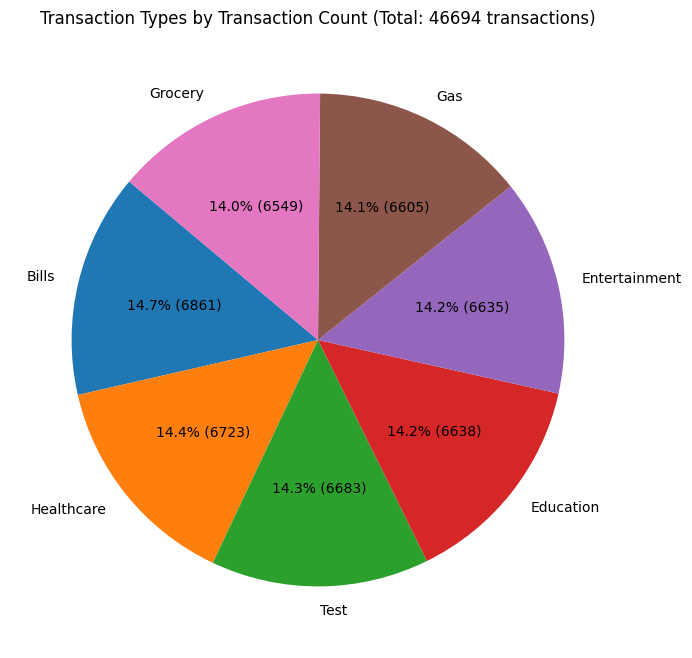

<Figure size 640x480 with 0 Axes>

In [77]:
#Req 3.1
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import secret
# Define your database connection details
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
# Establish a connection to the MySQL database
db = mysql.connector.connect(**db_config)
# Define your SQL query to get transaction types and their counts
query = """
SELECT TRANSACTION_TYPE, COUNT(*) as TransactionCount
FROM CDW_SAPP_CREDIT_CARD
GROUP BY TRANSACTION_TYPE
ORDER BY TransactionCount DESC
"""
# Fetch the data from the database using pandas
data = pd.read_sql(query, db)
# Set up data for the pie chart
labels = data["TRANSACTION_TYPE"]
sizes = data["TransactionCount"]
total_transactions = sum(sizes)  # Calculate the total number of transactions
# Create a pie chart with a title including the total number of transactions
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, p * total_transactions / 100), startangle=140)
plt.title(f"Transaction Types by Transaction Count (Total: {total_transactions} transactions)")
# Save the visualization as an image
plt.savefig("C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/transaction_type_highest_count.png")
# Show the pie chart and save
plt.show()
# Close the database connection
db.close()

C:\Users\Learner_9ZH3Z184\AppData\Local\Temp\ipykernel_28824\129042499.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, db)


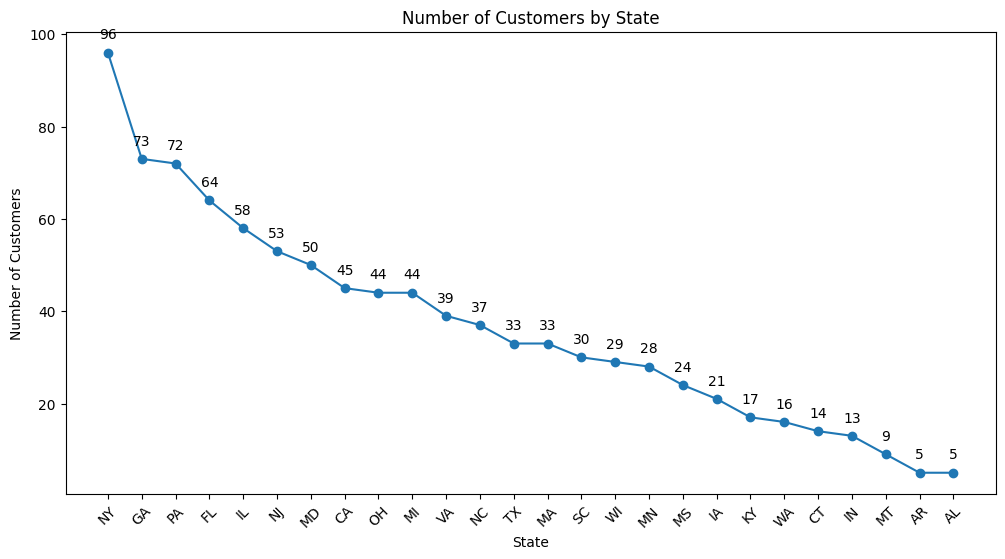

In [79]:
#Req 3.2
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import secret
# Define your database connection details
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
# Establish a connection to the MySQL database
db = mysql.connector.connect(**db_config)
# Define your SQL query to get the number of customers in each state
query = """
SELECT CUST_STATE, COUNT(*) as CustomerCount
FROM CDW_SAPP_CUSTOMER
GROUP BY CUST_STATE
ORDER BY CustomerCount DESC
"""
# Fetch the data from the database using pandas
data = pd.read_sql(query, db)
# Create a line graph to visualize the number of customers in each state
plt.figure(figsize=(12, 6))
plt.plot(data["CUST_STATE"], data["CustomerCount"], marker='o')
plt.title("Number of Customers by State")
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)

# Annotate the data points with the number of customers
for i, row in data.iterrows():
    plt.annotate(row["CustomerCount"], (row["CUST_STATE"], row["CustomerCount"]), textcoords="offset points", xytext=(0, 10), ha='center')
# Show the line graph and save
plt.savefig("C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/state_high_customer_count.png")

plt.show()
# Close the database connection
db.close()

C:\Users\Learner_9ZH3Z184\AppData\Local\Temp\ipykernel_28824\2457232611.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, db)


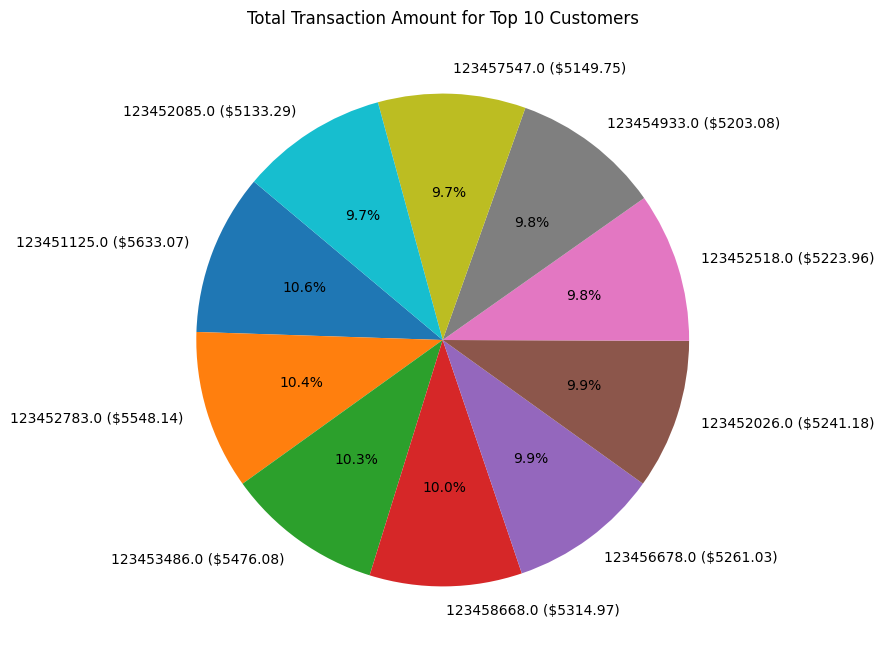

In [80]:
#Req 3.3
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import secret
# Define your database connection details
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
# Establish a connection to the MySQL database
db = mysql.connector.connect(**db_config)
# Define your SQL query to get the sum of transactions for the top 10 customers
query = """
SELECT CUST_SSN, SUM(TRANSACTION_VALUE) AS TotalTransactionAmount
FROM CDW_SAPP_CREDIT_CARD
GROUP BY CUST_SSN
ORDER BY TotalTransactionAmount DESC
LIMIT 10
"""
# Fetch the data from the database using pandas
data = pd.read_sql(query, db)
# Create a list of labels with customer SSNs and total transaction amounts
labels = [f"{row['CUST_SSN']} (${row['TotalTransactionAmount']:.2f})" for _, row in data.iterrows()]
# Create a list of total transaction amounts
sizes = data["TotalTransactionAmount"]
# Create a pie chart to visualize the total transaction amount for the top 10 customers
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Total Transaction Amount for Top 10 Customers")
# Save the visualization as an image
plt.savefig("C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/top_10_customers_transaction_amount.png")
# Show the pie chart
plt.show()
# Close the database connection
db.close()

In [ ]:
#Req 4.1, 4.2, 4.3
import requests
import mysql.connector
# API endpoint for the loan application dataset
api_url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
# Database connection configuration
db = mysql.connector.connect(
    host = "localhost",
    user = secret.mysql_username,
    passwd = secret.mysql_password,
    database = "creditcard_capstone" #Database in mysql
)
# Send a GET request to the API endpoint
response = requests.get(api_url)
# Check if the request was successful (status code 200)
if response.status_code == 200:
    loan_data = response.json()
    # Create a cursor to execute SQL commands
    cursor = db.cursor()
    # Define the table schema for CDW_SAPP_loan_application
    create_table_query = """
    CREATE TABLE IF NOT EXISTS CDW_SAPP_loan_application (
        Application_ID VARCHAR(20) PRIMARY KEY,
        Gender VARCHAR(10),
        Married VARCHAR(10),
        Dependents VARCHAR(10),
        Education VARCHAR(20),
        Self_Employed VARCHAR(10),
        Credit_History INT,
        Property_Area VARCHAR(20),
        Income VARCHAR(20),
        Application_Status VARCHAR(10)
    );
    """
    # Create the CDW-SAPP_loan_application table if it doesn't exist
    cursor.execute(create_table_query)
    # Insert data into the table
    insert_query = """
    INSERT INTO CDW_SAPP_loan_application (
        Application_ID, Gender, Married, Dependents, Education, Self_Employed,
        Credit_History, Property_Area, Income, Application_Status
    )
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """
    # Iterate through the loan data and insert it into the database
    for record in loan_data:
        data_tuple = (
            record["Application_ID"],
            record["Gender"],
            record["Married"],
            record["Dependents"],
            record["Education"],
            record["Self_Employed"],
            record["Credit_History"],
            record["Property_Area"],
            record["Income"],
            record["Application_Status"],
        )
        cursor.execute(insert_query, data_tuple)
    # Commit the changes and close the cursor and database connection
    db.commit()
    cursor.close()
    db.close()
    print("Loan data loaded into the RDBMS.")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

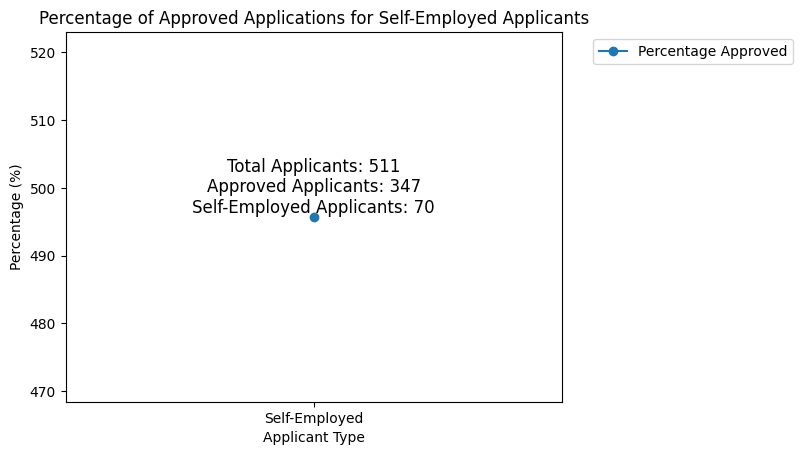

In [81]:
#Req 5.1
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
# Establish a connection to the MySQL database
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
db = mysql.connector.connect(**db_config)
# Define SQL queries to get the count of approved and self-employed applications
total_query = "SELECT COUNT(*) FROM cdw_sapp_loan_application"
approved_query = "SELECT COUNT(*) FROM cdw_sapp_loan_application WHERE APPLICATION_STATUS = 'Y'"
self_employed_query = "SELECT COUNT(*) FROM cdw_sapp_loan_application WHERE SELF_EMPLOYED = 'Yes'"
# Execute the queries
cursor = db.cursor()
cursor.execute(total_query)
total_applications = cursor.fetchone()[0]
cursor.execute(approved_query)
approved_applications = cursor.fetchone()[0]
cursor.execute(self_employed_query)
self_employed_applications = cursor.fetchone()[0]
# Calculate the percentage of approved applications for self-employed applicants
percentage_approved_for_self_employed = (approved_applications / self_employed_applications) * 100
# Create a line graph
x = ["Self-Employed"]
y = [percentage_approved_for_self_employed]
plt.plot(x, y, marker='o')
# Include the total, approved, and total applicants in the graph
plt.text("Self-Employed", percentage_approved_for_self_employed,
         f"Total Applicants: {total_applications}\nApproved Applicants: {approved_applications}\nSelf-Employed Applicants: {self_employed_applications}",
         fontsize=12, va='bottom', ha='center')
plt.title("Percentage of Approved Applications for Self-Employed Applicants")
plt.xlabel("Applicant Type")
plt.ylabel("Percentage (%)")

#Moving Legend
plt.legend(['Percentage Approved'], bbox_to_anchor=(1.05, 1), loc='upper left')
# Save the visualization as an image
plt.savefig('C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/self_employed_approval.png')
# Show the line graph
plt.show()
# Close the database connection
db.close()

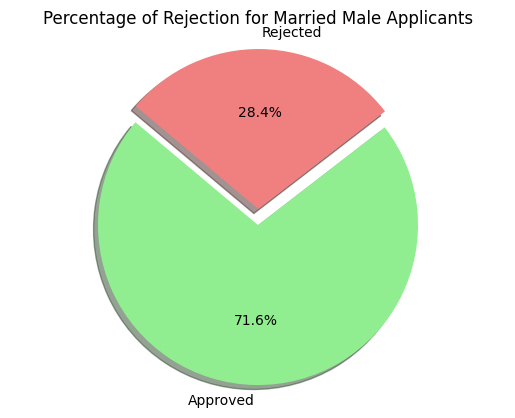

In [82]:
#Req 5.2

import mysql.connector
import matplotlib.pyplot as plt
# Establish a connection to the MySQL database
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
db = mysql.connector.connect(**db_config)
# Define SQL queries to count the number of married male applicants and the number of rejected applications among them
married_male_query = "SELECT COUNT(*) FROM cdw_sapp_loan_application WHERE Gender = 'Male' AND Married = 'Yes'"
rejected_married_male_query = "SELECT COUNT(*) FROM cdw_sapp_loan_application WHERE Gender = 'Male' AND Married = 'Yes' AND Application_Status = 'N'"
# Execute the queries
cursor = db.cursor()
cursor.execute(married_male_query)
married_male_count = cursor.fetchone()[0]
cursor.execute(rejected_married_male_query)
rejected_married_male_count = cursor.fetchone()[0]
# Calculate the percentage of rejection for married male applicants
percentage_rejection_married_male = (rejected_married_male_count / married_male_count) * 100
# Create a pie chart
labels = ['Approved', 'Rejected']
sizes = [married_male_count - rejected_married_male_count, rejected_married_male_count]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)  # Explode the 'Rejected' slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Percentage of Rejection for Married Male Applicants")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
# Save the visualization as an image
plt.savefig('C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/rejection_married_male.png', bbox_inches='tight')
# Show the pie chart
plt.show()
# Close the database connection
db.close()

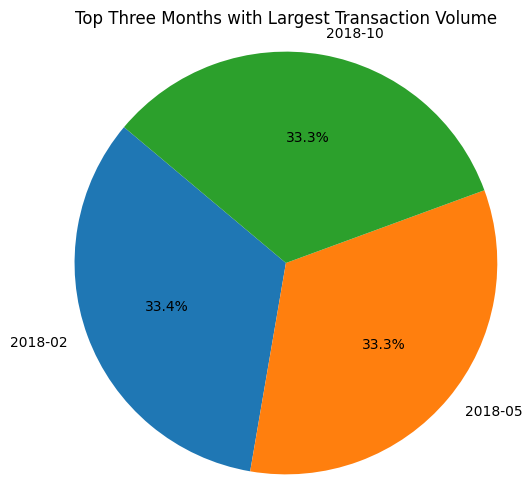

In [83]:
#Req 5.3

import mysql.connector
import matplotlib.pyplot as plt
# Establish a connection to the MySQL database
db_config = {
    "host": "localhost",
    "user": secret.mysql_username,
    "passwd": secret.mysql_password,
    "database": "creditcard_capstone"
}
db = mysql.connector.connect(**db_config)
# Define an SQL query to retrieve the top three months with the largest transaction volume
query = """
    SELECT DISTINCT YEAR(TIMEID) AS year, MONTH(TIMEID) AS month, COUNT(*) AS transaction_count
    FROM cdw_sapp_credit_card
    GROUP BY year, month
    ORDER BY transaction_count DESC
    LIMIT 3
"""
# Execute the query and fetch the data
cursor = db.cursor()
cursor.execute(query)
results = cursor.fetchall()
# Extract year, month, and transaction count data
months = []
transaction_counts = []
for result in results:
    year = result[0]
    month = result[1]
    count = result[2]
    if year is not None and month is not None and count is not None:
        months.append(f"{year}-{month:02d}")
        transaction_counts.append(count)
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(transaction_counts, labels=months, autopct='%1.1f%%', startangle=140)
plt.title("Top Three Months with Largest Transaction Volume")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
# Save the visualization as an image
plt.savefig('C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/top_three_months.png', bbox_inches='tight')
# Show the pie chart
plt.show()
# Close the database connection
db.close()

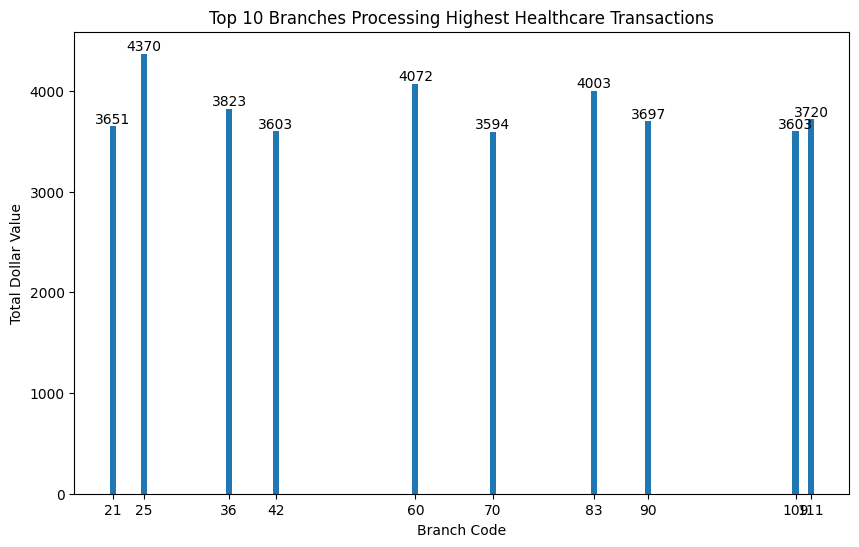

In [84]:
#Req 5.4

import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
# Connect to MySQL database
db = mysql.connector.connect(
    host = "localhost",
    user = secret.mysql_username,
    passwd = secret.mysql_password,
    database = "creditcard_capstone" #Database in mysql
)
# Define your SQL query to calculate the total dollar value of healthcare transactions per branch
query = """
    SELECT BRANCH_CODE, SUM(TRANSACTION_VALUE) AS TOTAL_DOLLAR
    FROM CDW_SAPP_CREDIT_CARD
    WHERE TRANSACTION_TYPE = 'Healthcare'
    GROUP BY BRANCH_CODE
    ORDER BY TOTAL_DOLLAR DESC
    LIMIT 10
"""
# Execute the query
cursor = db.cursor()
cursor.execute(query)
# Fetch the results
results = cursor.fetchall()
# Close the database connection
db.close()
# Prepare the data for plotting
branch_codes = [row[0] for row in results]
total_dollars = [row[1] for row in results]
# Create a bar graph with labeled branches
plt.figure(figsize=(10, 6))
plt.bar(branch_codes, total_dollars)
plt.title("Top 10 Branches Processing Highest Healthcare Transactions")
plt.xlabel("Branch Code")
plt.ylabel("Total Dollar Value")
# Label the branches with their codes
for i, total in enumerate(total_dollars):
    plt.text(branch_codes[i], total, str(int(total)), ha='center', va='bottom')
# Include specific branch codes on the x-axis
plt.xticks(branch_codes)
# Save the visualization to a file
plt.savefig('C:/Users/Learner_9ZH3Z184/Documents/GitHub/Credit-Card/Final_Project/healthcare_transactions.png')
# Show the bar graph
plt.show()